<img src="images/RIINBRE-Logo.jpg" width="400" height="400"><img src="images/MIC_Logo.png" width="600" height="600">

# Analysis of Biomedical Data for Biomarker Discovery
## Submodule 7: Exploratory Analysis of Proteomics IRI Data
### Dr. Christopher L. Hemme
### Director, [RI-INBRE Molecular Informatics Core](https://web.uri.edu/riinbre/mic/)
### The University of Rhode Island College of Pharmacy
Last Updated: March 22, 2023

---

## Introduction

Omics data allows us to evaluate potential biomarkers on a systematic scale.  Instead of picking and choosing individual biomarkers, omics data allows us to identify large numbers of correlated variables that may indicate broad biological trends.  There are several benefits of such a strategy.  First, we may identify unknown or unanticipated biomarkers that were not obvious candidates but which are clearly correlated to (but not necessarily causative of) disease states.  Second, we can map this data to biological networks, allowing us to identify metabolic pathways correlated to disease states or to identify regulatory networks that can indicate mechanisms by which the state changes are occurring.  The cost of using omics data however is the so-called "curse of dimensionality".  Omics data involves thousands of features (e.g. expressed genes, active proteins, etc.), most of which are not actively changed across states.  Identifying the correlated variables and determining their statistical and biological significance is a challenge when dealing with a single omics layer such as the proteome.  The challenge becomes even greater when attempting to correlate results across different omics layers (known as multiomics) or when comparing similar results across laboratories (meta-analysis).  For this module, we will focus on a traditional bulk proteomics experiment from the rat renal IRI data to identify proteins significantly affected by IRI.

<div class="alert alert-block alert-info">
<b>&#9995; Tip:</b> Blue boxes will indicate helpful tips.</div>

<div class="alert alert-block alert-warning">
<b>&#127891; Note:</b> Used for interesting asides or notes.
</div>

<div class="alert alert-block alert-success">
<b>&#9997; Reference:</b> This box indicates a reference for an attached figure or table.
</div>

<div class="alert alert-block alert-danger">
<b>&#128721; Caution:</b> A red box indicates potential hazards or pitfalls you may encounter.
</div>

---

## Identification of Proteomic Biomarkers

### Pre-Analysis Prep

Let's start by loading the required R packages and our experimental object.

In [1]:
if(!require(devtools)) install.packages("devtools")
devtools::install_github("kassambara/factoextra")

if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
library('BiocManager')

bioc_packages <- c("limma", "ComplexHeatmap", "M3C")
installed_bioc_packages <- bioc_packages %in% rownames(installed.packages())
if (any(installed_bioc_packages == FALSE)) {BiocManager::install(bioc_packages[!installed_bioc_packages])}

BiocManager::install("preprocessCore")
BiocManager::install("preprocessCore", configure.args="--disable-threading", force = TRUE)

packages <- c("plyr", "tidyverse", "factoextra")
installed_packages <- packages %in% rownames(installed.packages())
if (any(installed_packages == FALSE)) {install.packages(packages[!installed_packages])}

Loading required package: devtools

Loading required package: usethis

Skipping install of 'factoextra' from a github remote, the SHA1 (1689fc74) has not changed since last install.
  Use `force = TRUE` to force installation


Attaching package: ‘BiocManager’


The following object is masked from ‘package:devtools’:

    install


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org

Bioconductor version 3.16 (BiocManager 1.30.20), R 4.2.3 (2023-03-15)

Installing package(s) 'BiocVersion', 'limma', 'ComplexHeatmap', 'M3C'

also installing the dependencies ‘shape’, ‘rjson’, ‘BiocGenerics’, ‘S4Vectors’, ‘snow’, ‘RSpectra’, ‘circlize’, ‘GetoptLong’, ‘clue’, ‘GlobalOptions’, ‘IRanges’, ‘matrixStats’, ‘doParallel’, ‘doSNOW’, ‘matrixcalc’, ‘Rtsne’, ‘corpcor’, ‘umap’


Installation paths not writeable, unable to update packages
  path: /usr/lib/R/librar

In [2]:
require('preprocessCore')
require('limma')
require('ComplexHeatmap')
require('plyr')
require('tidyverse')
require('factoextra')

Loading required package: preprocessCore

Loading required package: limma

Loading required package: ComplexHeatmap

Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Loading required package: plyr

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ d

In [3]:
exp_obj <- readRDS(file = "data/Saved_Data/exp_obj.rds")

### Data Normalization

When working with data, it's often a good idea to work with copies of your data instead of the raw data itself to avoid accidentally modifying the original data.  In our case, it's not a big deal since we could just reload the experimental object, but we can save ourselves some typing by saving the proteome data and metadata into separate variables.

In [4]:
#loading the experimental object and extract the metadata
proteome <- exp_obj$data$proteomics$log2
metadata <- exp_obj$metadata
metadata

Sample,Treatment,Time,Batch
<chr>,<fct>,<fct>,<fct>
LK83.1,CTRL,0,2
LK83.2,CTRL,0,2
LK83.3,CTRL,0,2
LK83.4,CTRL,0,2
LK83.5,CTRL,0,2
X83.6,CTRL,0,1
Control1,CTRL,0,1
Control2,CTRL,0,1
X05.1,PLB,1,1


Remember that our data was log2 transformed.  Because the proteomic signal data spans a wide range of values, log transforming the data linearizes the data making it more normally distributed.  Let's look at a boxplot of the data to see how it looks.

In [5]:
head(proteome)

,LK83.1,LK83.2,LK83.3,LK83.4,LK83.5,X83.6,Control1,Control2,X05.1,X05.2,⋯,X13.5,X55.1,X55.2,X61.2,X61.1,X19.2,X19.5,X71.1,X71.2,X71.4
;Ddx21,-2.8310894,-2.243521,-2.2444980,-2.5816148,-2.2365411,-2.4905584,-2.4277630,-2.5980945,-2.76399838,-2.6204152,⋯,-0.8536026,-1.3723008,-0.8478262,-1.2335957,-1.6215210,-1.829292,-1.8996436,-1.1784085,-1.12713161,-1.0325136
;Dut,1.3084652,1.232727,1.0128795,1.2346853,1.2111390,1.4473006,1.5084148,1.4622230,1.30990509,1.4614075,⋯,0.8544308,1.3261935,1.6451215,1.3603152,1.2202625,1.114411,0.8827344,1.3228348,1.38203696,1.4144042
;Eno1,6.7092991,6.811231,6.7679767,6.6384804,6.7632126,7.0238761,7.0140582,7.0504316,6.72270899,6.6403780,⋯,6.5469118,6.6652557,6.7770567,6.7196458,6.5222593,6.640121,6.5656155,6.8393434,6.72218874,6.3898134
;Hist2h2aa3,8.8649762,9.004159,8.8358865,9.0611704,8.5120226,8.2783486,7.6943046,7.6276330,7.40271288,7.5572870,⋯,9.3533545,9.0588841,8.9278379,8.8434693,8.9801655,9.619392,9.5190045,9.1063450,9.17174815,9.3949067
;LOC108349606;Rpl7a,2.9920865,2.887537,2.8997688,3.0691878,2.2684492,0.4413229,-0.1346705,-0.2648891,0.88260154,0.6553741,⋯,3.7070504,3.0347338,1.5738377,1.6478360,3.2288760,3.744489,3.7208217,2.7187798,2.18140601,2.6458556
;RGD1564138;;Rpl29,0.6968846,0.509373,0.1751547,0.8558312,-0.1353406,0.2496506,-2.0423369,-2.2141412,-0.01059898,0.6498641,⋯,1.6903624,0.8500336,-0.6667843,-0.1269065,0.5192018,1.601948,1.8274626,0.5148095,0.04570927,0.8553249


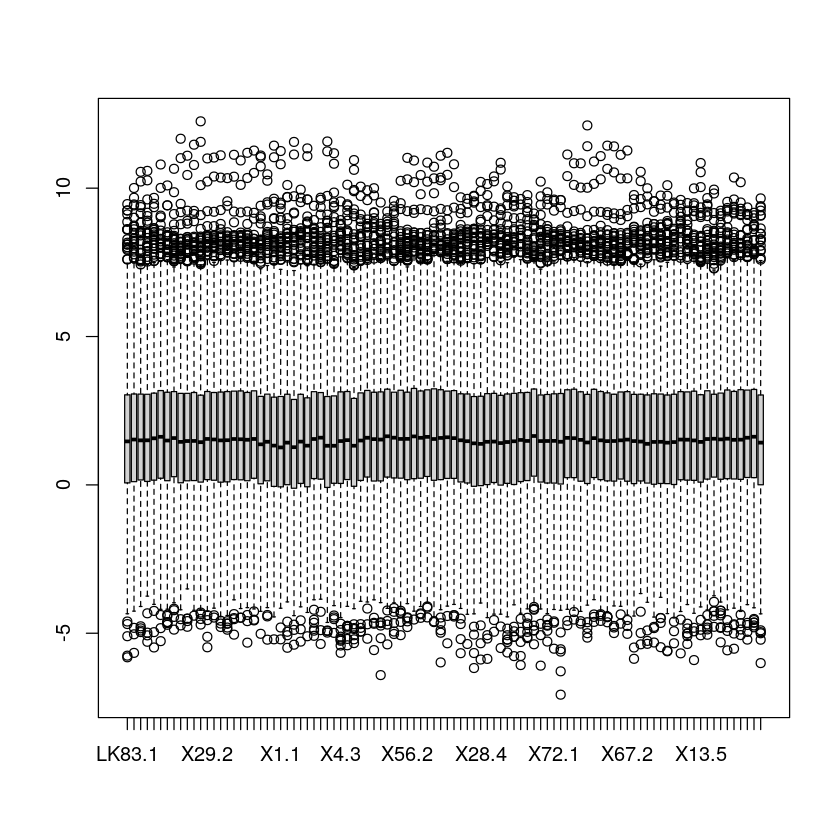

In [6]:
boxplot(proteome)

We can go a step further and quantile normalize the data.  In quantile normalization, we are making the distribution of the data in each sample identical in their statistical properties.  We will use the <i>normalize.quantiles</i> function from the <b>preprocessCore</b> package to do the normalization. This step is important to decrease variations or noise that could cause results to skew within the dataset. This also provides power to downstream analysis by grouping liked values together to select important features which we will be doing in submodule 9. 

<div class="alert alert-block alert-success">
<b>&#9997; Reference:</b> For more information see the https://academic.oup.com/bib/article/19/1/1/2562889
</div>

In [7]:
#normalize the proteome data
proteome_norm <- normalize.quantiles(proteome)
rownames(proteome_norm) <- rownames(proteome)
colnames(proteome_norm) <- colnames(proteome)
head(proteome_norm)

,LK83.1,LK83.2,LK83.3,LK83.4,LK83.5,X83.6,Control1,Control2,X05.1,X05.2,⋯,X13.5,X55.1,X55.2,X61.2,X61.1,X19.2,X19.5,X71.1,X71.2,X71.4
;Ddx21,-2.6727507,-2.1901850,-2.2421496,-2.5998268,-2.301827,-2.5834750,-2.4167815,-2.7997399,-2.87909105,-2.6346873,⋯,-0.8813137,-1.4257912,-0.9542488,-1.3635716,-1.7654583,-1.895894,-2.0458740,-1.3325472,-1.21081692,-0.9302010
;Dut,1.3352930,1.2189122,1.0112785,1.2167170,1.143424,1.3177368,1.5065033,1.3638557,1.35677411,1.4808844,⋯,0.8834256,1.2554022,1.6140508,1.3004754,1.1461517,1.100273,0.8182732,1.2146009,1.27887874,1.4912903
;Eno1,6.6852294,6.7366109,6.6587706,6.5799006,6.765378,7.0505327,6.9041000,7.0851305,6.84793209,6.7123751,⋯,6.6587706,6.7123751,6.7653779,6.7366109,6.5357016,6.736611,6.5799006,6.8752445,6.63468865,6.4776125
;Hist2h2aa3,8.7459919,8.7459919,8.6142455,8.7459919,8.388745,8.3105865,7.7462550,7.5541497,7.33375498,7.5541497,⋯,8.9806716,8.7459919,8.9806716,8.9806716,8.7459919,9.956039,9.9560393,9.3543257,10.39987193,9.9560393
;LOC108349606;Rpl7a,3.0713768,2.8954008,2.9075111,3.1356851,2.295193,0.3704181,-0.1695525,-0.3840378,0.90063784,0.6645827,⋯,3.7794672,2.9816773,1.5106105,1.6160616,3.1392418,3.728905,3.6666072,2.5993958,2.05298796,2.6574290
;RGD1564138;;Rpl29,0.7549548,0.5360638,0.1302277,0.8598805,-0.190857,0.1492028,-2.0770394,-2.3909583,0.01573162,0.6548808,⋯,1.7940819,0.7752549,-0.8205572,-0.1583842,0.4334262,1.585295,1.7964252,0.3843435,-0.06170927,0.9387404


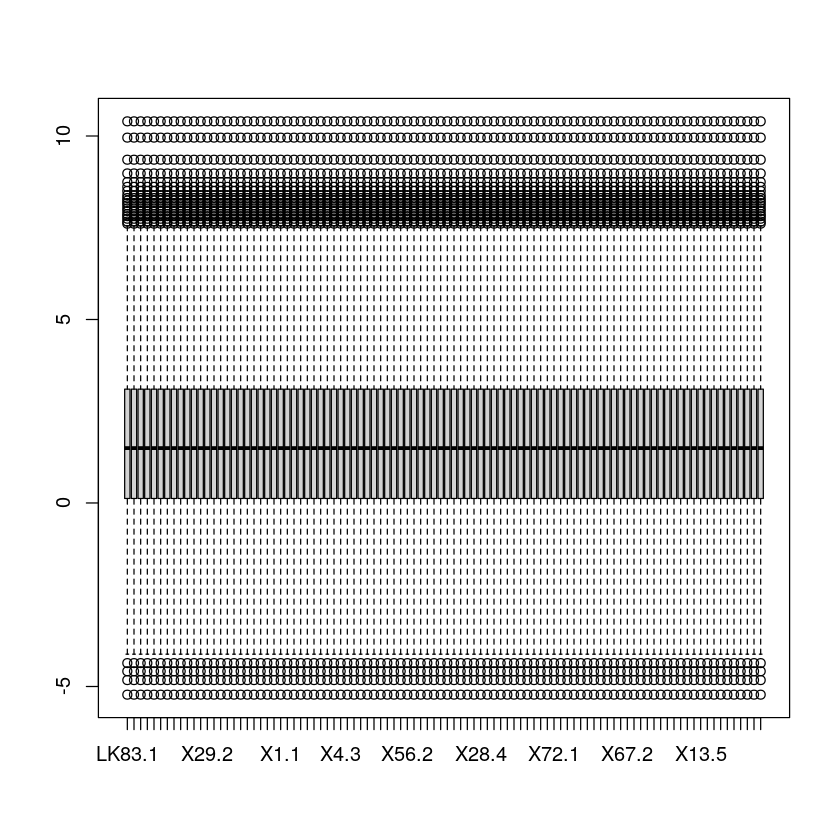

In [8]:
boxplot(proteome_norm)

<div class="alert alert-block alert-danger">
<b>&#128721; Caution:</b> There are many ways to normalize data, and even different strategies for using quantile normalization.  No normalization method is perfect and some may even introduce error into your data.  Tools such as the <b>NormalyzerDE</b> package in BioConductor can help you determine the best normalization method for your data.
</div>

### Dimensionality Reduction (PCA and MDS)

Now we'll begin the exploratory analysis.  Let's start with a principal component analysis (PCA).  PCA is useful to get a feel for similarities in our sample proteomes and if there are any batch effects we need to account for.  PCA is a dimensionality reduction technique in which we are linearly transforming our data to a new set of axes (called principal components) that define the variability in the data.  Typically, the first 2-3 principal components (PC) account for the majority of variation in the data, making visualizing the data much easier.  PCA also allows us to identify groups of correlated variables which help separate groups of similar samples (see biplots below). 

There are many ways to calculate and visualize PCA data in R.  We'll use the base R <i>prcomp</i> function and the visualization tools in the <b>factoextra</b> package.  First, let's create a scree plot to see which of our principal components are relevant.  The scree plot is a bar chart showing the amount of variability accounted for by each PC.

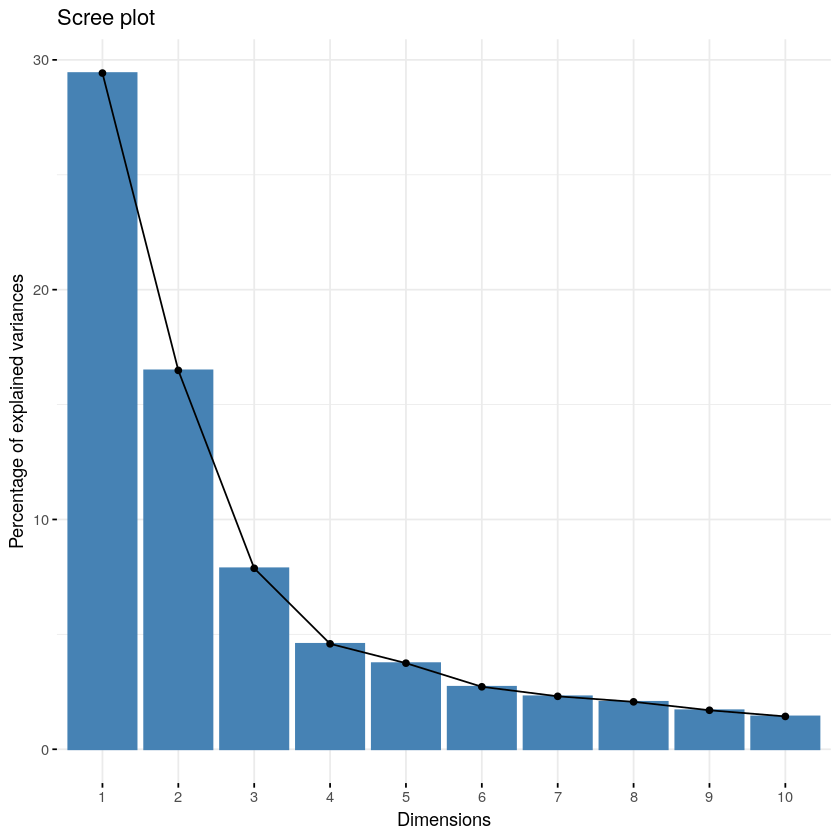

In [9]:
#the Dimensions shown in the plot below can also be called Principal Components
proteome_pca <- prcomp(t(na.omit(proteome_norm)), center = TRUE, scale. = TRUE)
fviz_eig(proteome_pca)

<div class="alert alert-block alert-warning">
    <b>&#127891; Note:</b> Reminder that PCA decomposes the data matrix <b>X</b> into matrices <b>U</b> and <b>V</b>, where

$$X = U \cdot V = UV^T$$

$U$ = Scores matrix, which is the original data rotated into the new coordinate system

$V$ = Loadings matrix, which is the weights applied to each data point in the new coordinate system
</div>

Most of the variability seems to be in the first two PC's, so that's what we'll plot.  Often you will see on a PCA plot that we include the information for both the individual data points and the variables (we call this a biplot).  This is often useful to us because it gives us an indication of which variables are defining the groups we see in our PCA.  We won't plot the variables right now since adding 2000+ proteins to the plot will be too messy to be useful.  In general though, the biplot tends to follow the same patterns as the linear regression results from differential analysis, which we will see in the next chapter.

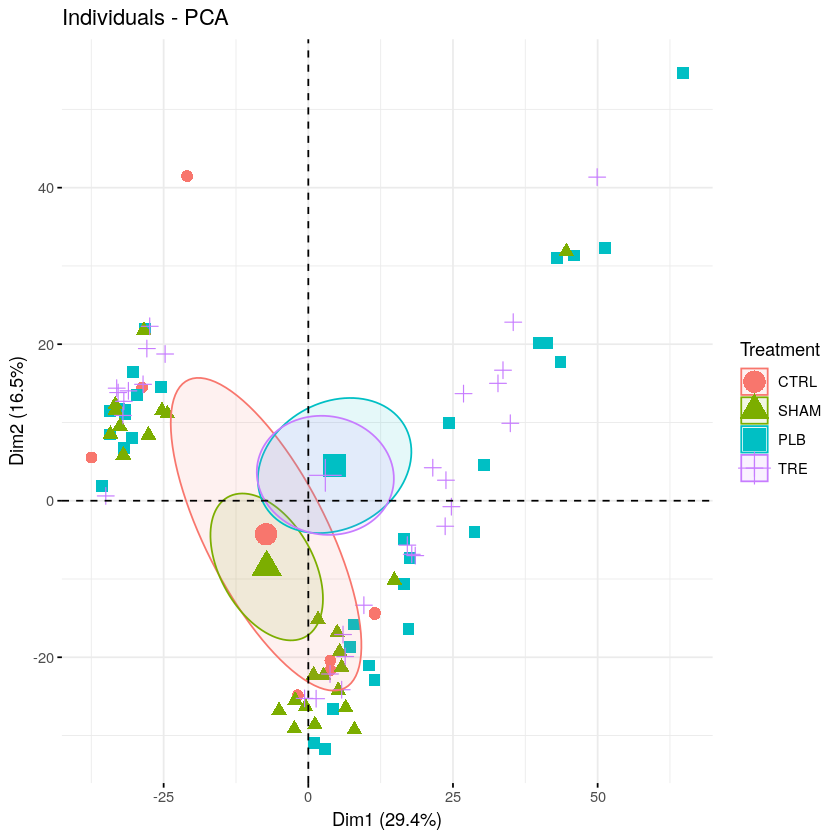

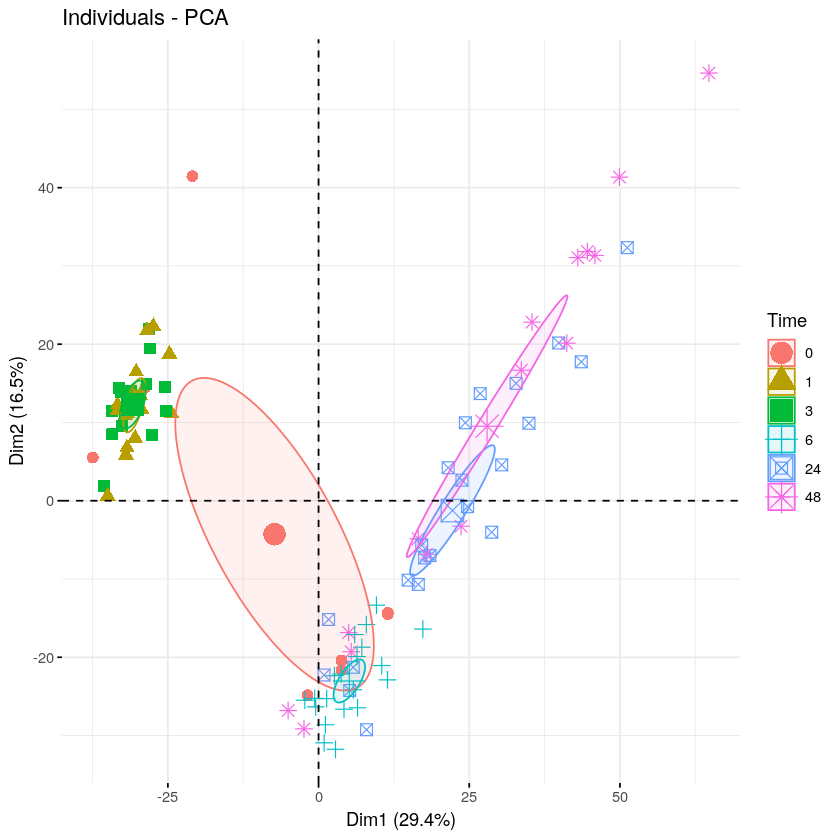

In [10]:
#plot the PCA plot by Treatment
fviz_pca_ind(proteome_pca,
             col.ind = metadata$Treatment,
             addEllipses = TRUE,
             repel = TRUE,
             ellipse.type = "confidence",
             legend.title = "Treatment",
             pointsize = 3,
             label = "none"
             )
#plot the PCA plot by Time
fviz_pca_ind(proteome_pca,
             col.ind = metadata$Time,
             addEllipses = TRUE,
             repel = TRUE,
             ellipse.type = "confidence",
             legend.title = "Time",
             pointsize = 3,
             label = "none"
             )

At first glance, there appears to be a strong separation by time, with earlier time points primarily in their own cluster.  However, if you remember, this data was collected in batches and therefore we have to account for any potential batch effects.  Let's replot the data based on that batch column.

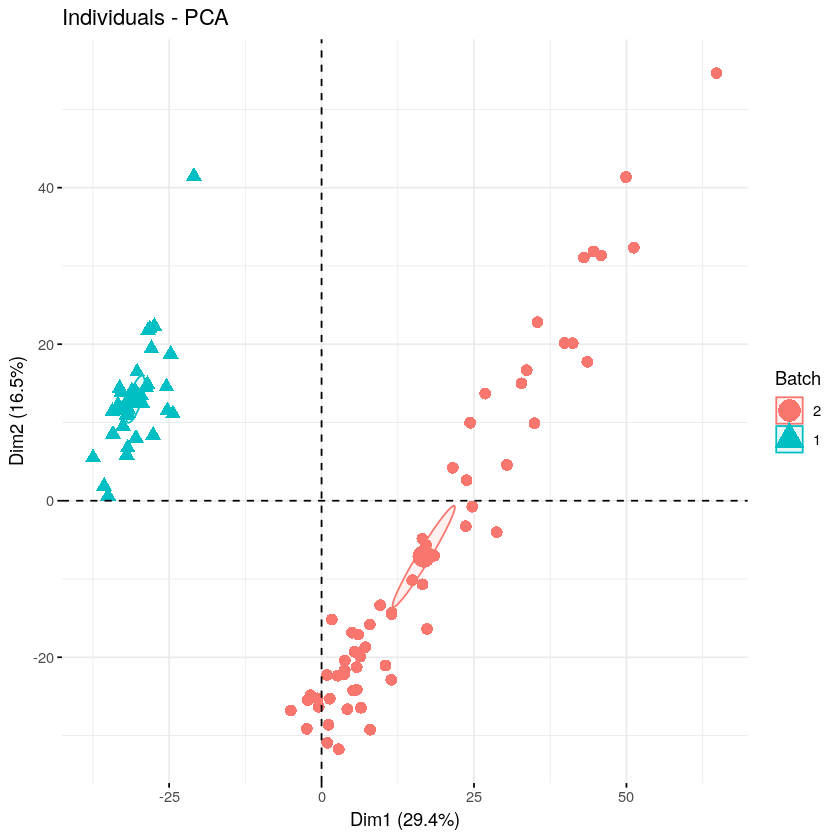

In [11]:
fviz_pca_ind(proteome_pca,
             col.ind = metadata$Batch,
             addEllipses = TRUE,
             repel = TRUE,
             ellipse.type = "confidence",
             legend.title = "Batch",
             pointsize = 3,
             label = "none"
             )

We can now clearly see that this separation is based on the batch effect which must be corrected.  For the purposes of exploratory analysis, we will use the <i>removeBatchEffect</i> function in <b>limma</b>.

<div class="alert alert-block alert-danger">
<b>&#128721; Caution:</b> Batch correction can be tricky in that it can sometimes introduce strange artifacts into your data.  Using <i>removeBatchEffect</i> is fine for exploratory analysis, but for differential analysis, it is better to include the batch column as an additional covariate or as a random effect in a linear mixed model. We will use this method when we do the differential analysis.
</div>

In [12]:
proteome_norm_batch <- removeBatchEffect(proteome_norm, batch = metadata$Batch)

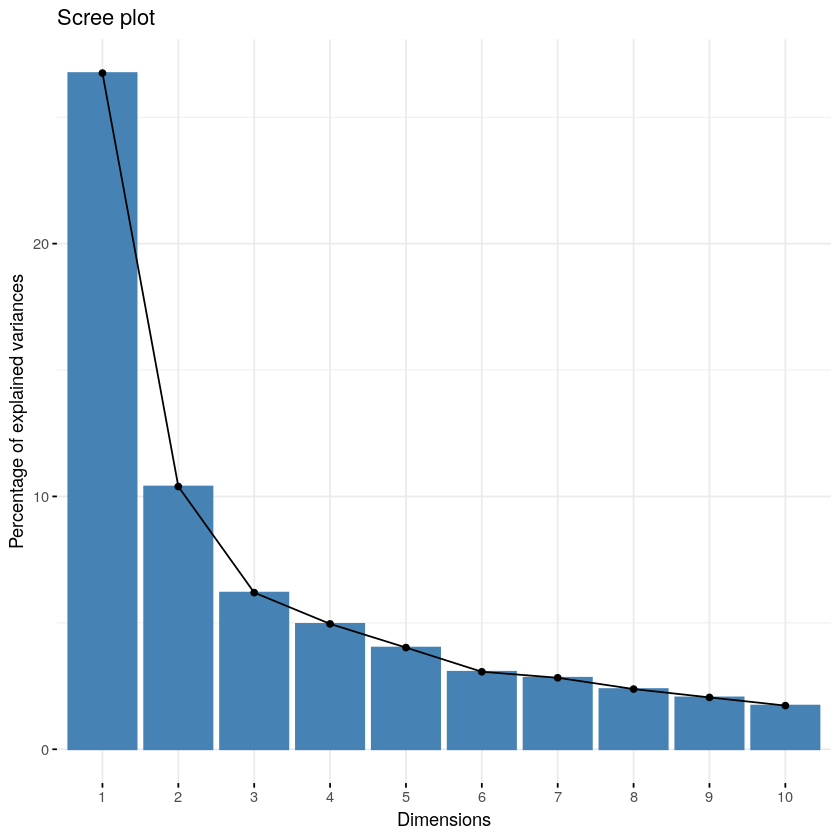

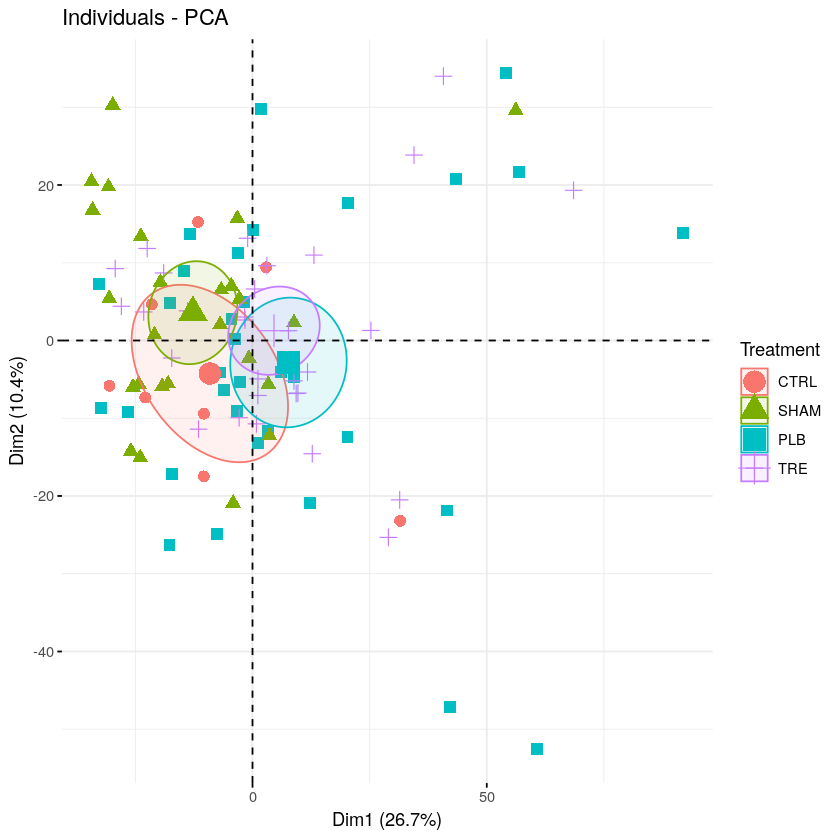

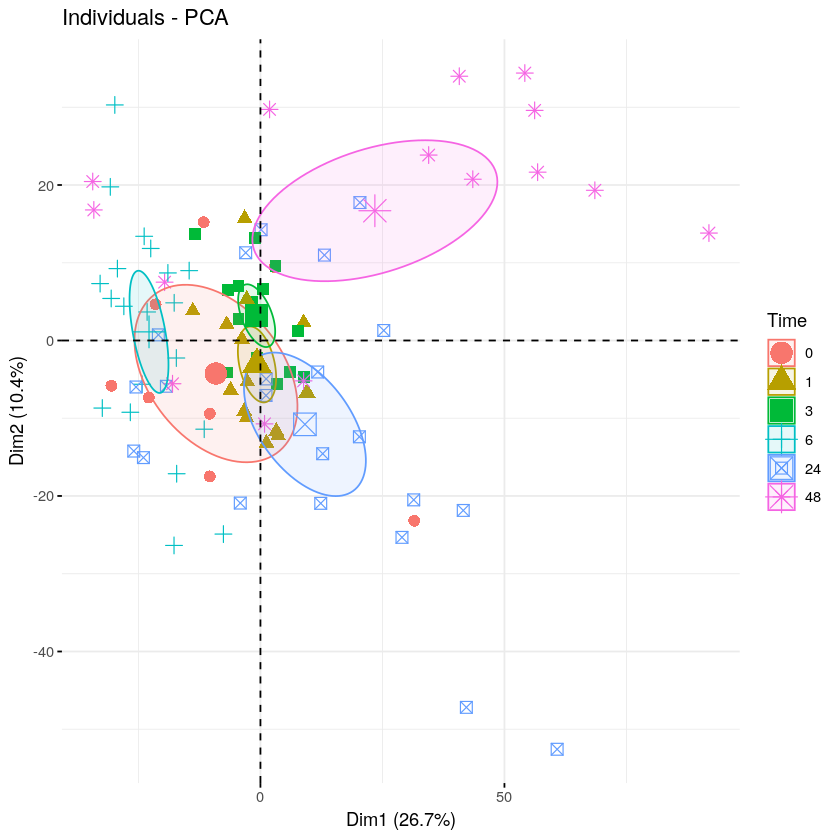

In [13]:
#replot the scree plot and PCA plots without batch effect
proteome_norm_batch_pca <- prcomp(t(na.omit(proteome_norm_batch)), center = TRUE, scale. = TRUE)
fviz_eig(proteome_norm_batch_pca)
fviz_pca_ind(proteome_norm_batch_pca,
             col.ind = metadata$Treatment,
             addEllipses = TRUE,
             repel = TRUE,
             ellipse.type = "confidence",
             legend.title = "Treatment",
             pointsize = 3,
             label = "none"
             )
fviz_pca_ind(proteome_norm_batch_pca,
             col.ind = metadata$Time,
             addEllipses = TRUE,
             repel = TRUE,
             ellipse.type = "confidence",
             legend.title = "Time",
             pointsize = 3,
             label = "none"
             )

Now we see that the batch effect is gone, but our data also doesn't cluster as strongly, though there does seem to be some separation in later time points.  Let's clean these plots up by limiting the PCA to only the 100 most highly variable proteins.  This code may look a bit complicated, but what it is doing is calculating the variance of each row, sorting the rows, and extracting the top 100 most variable rows, and then run the PCA on that subset.  In this way, we might see stronger separation.

<div class="alert alert-block alert-danger">
<b>&#128721; Caution:</b> For exploratory analysis, limiting the analysis to the most variable rows is fine.  When we do differential analysis however, we will need to include most or all data points in our regression model.
</div>

In [14]:
#scree plot with the top 100 variable proteins
high_var = order(apply(proteome_norm_batch, 1, var), decreasing=TRUE)[1:100]
proteome_norm_batch_pca_sub <- prcomp(t(na.omit(proteome_norm_batch[high_var,])), center = TRUE, scale. = TRUE)

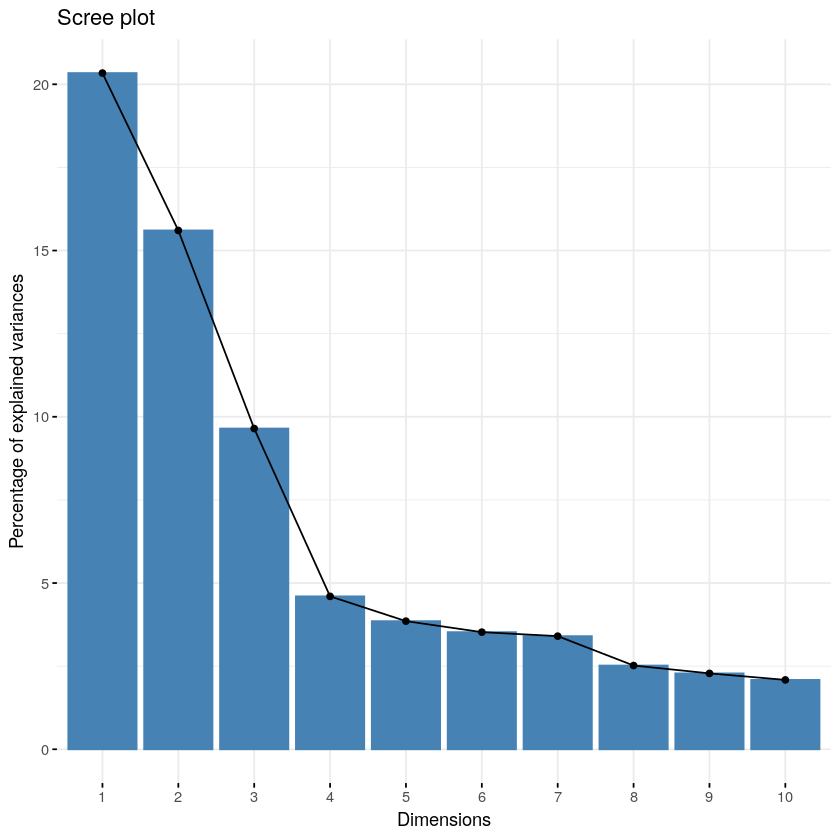

In [15]:
fviz_eig(proteome_norm_batch_pca_sub)

Our new scree plot suggests a fair amount of variability in the third PC, so we can plot that as well. 

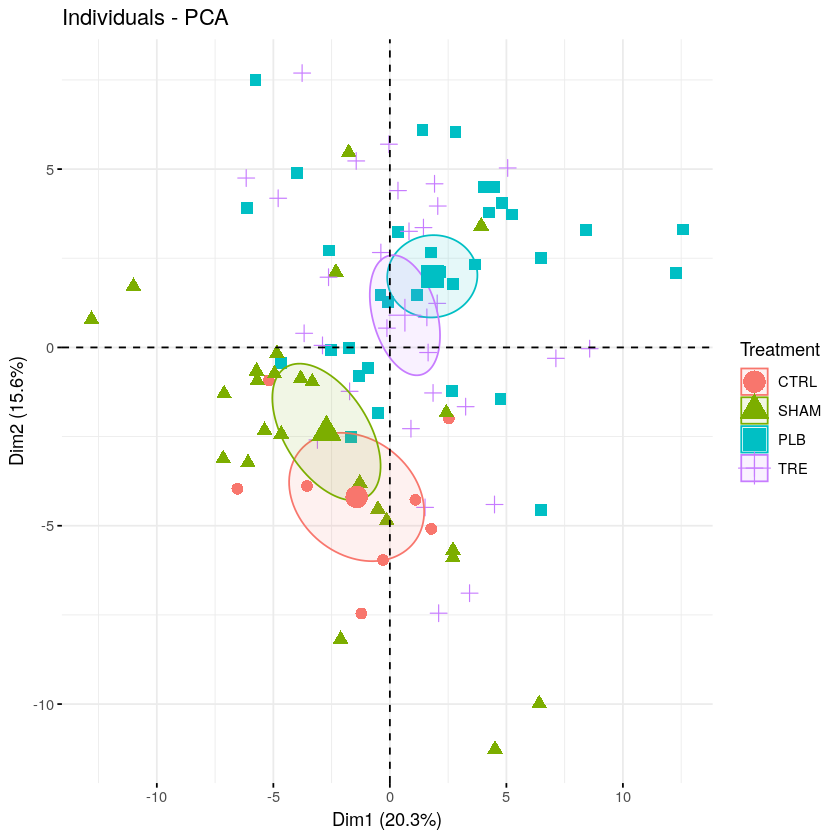

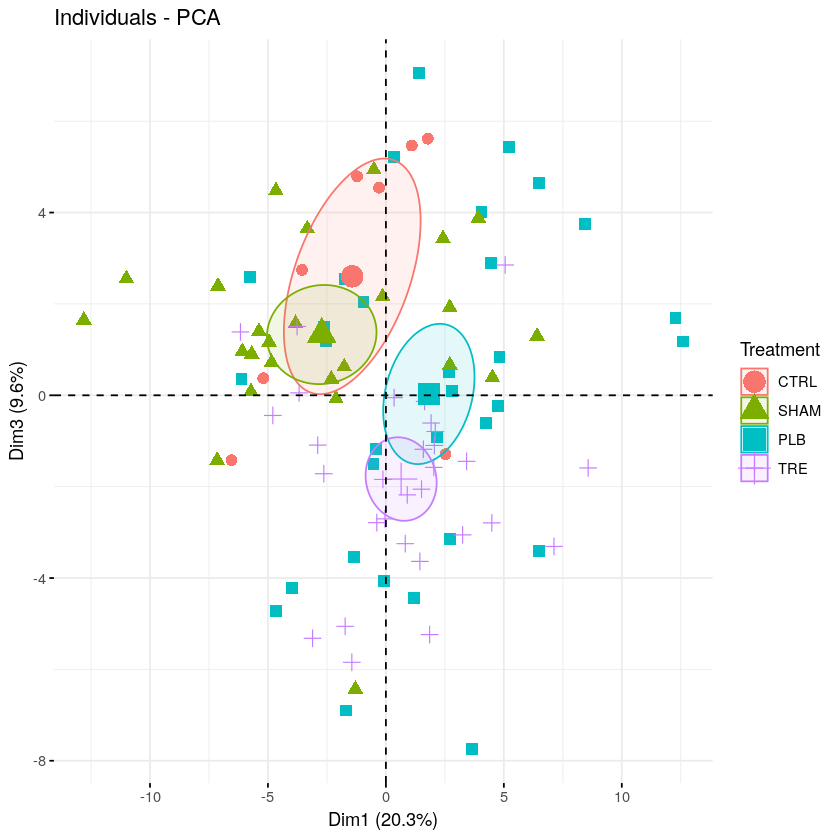

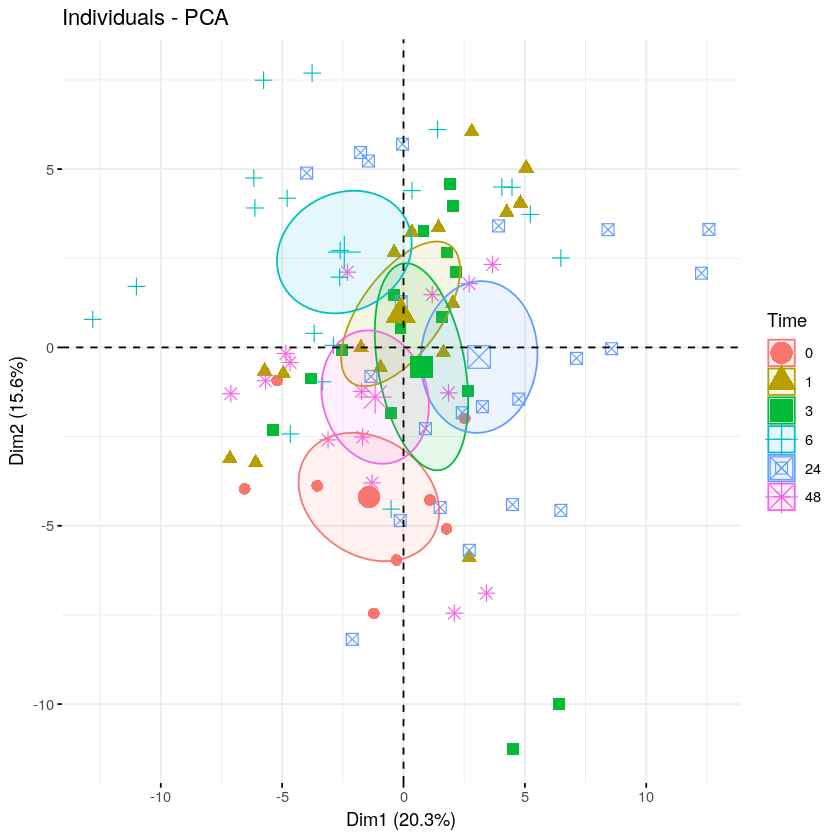

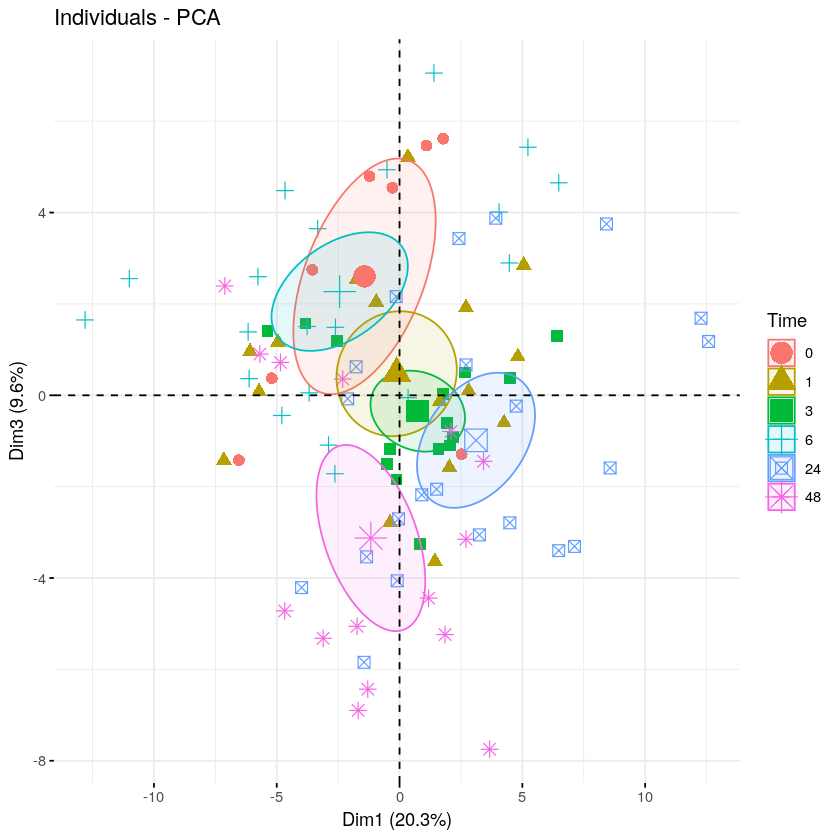

In [16]:
fviz_pca_ind(proteome_norm_batch_pca_sub,
             col.ind = metadata$Treatment,
             addEllipses = TRUE,
             repel = TRUE,
             ellipse.type = "confidence",
             legend.title = "Treatment",
             pointsize = 3,
             label = "none"
             )
#PCA plot looking at the 3 PC or dimension based on the Treatment variable
fviz_pca_ind(proteome_norm_batch_pca_sub,
             axes = c(1,3),
             col.ind = metadata$Treatment,
             addEllipses = TRUE,
             repel = TRUE,
             ellipse.type = "confidence",
             legend.title = "Treatment",
             pointsize = 3,
             label = "none"
             )
fviz_pca_ind(proteome_norm_batch_pca_sub,
             col.ind = metadata$Time,
             addEllipses = TRUE,
             repel = TRUE,
             ellipse.type = "confidence",
             legend.title = "Time",
             pointsize = 3,
             label = "none"
             )
#PCA plot looking at the 3 PC or dimension based on the Time variable
fviz_pca_ind(proteome_norm_batch_pca_sub,
             axes = c(1,3),
             col.ind = metadata$Time,
             addEllipses = TRUE,
             repel = TRUE,
             ellipse.type = "confidence",
             legend.title = "Time",
             pointsize = 3,
             label = "none"
             )

Now we can start to see some separation between the control/sham and the placebo/treprostinil samples, and maybe some separation between placebo and treprostinil samples on the third PC.  This is consistent with what we saw on the scatter plots in the previous chapter.  We want to be careful not to read too much into the PCA plots, but this suggests that when we do the differential analysis, we will probably need to account for both covariates in some fashion.  Let's see which proteins are driving this separation.  Since we are only looking at 100 proteins, let's see what the variable plot looks like.

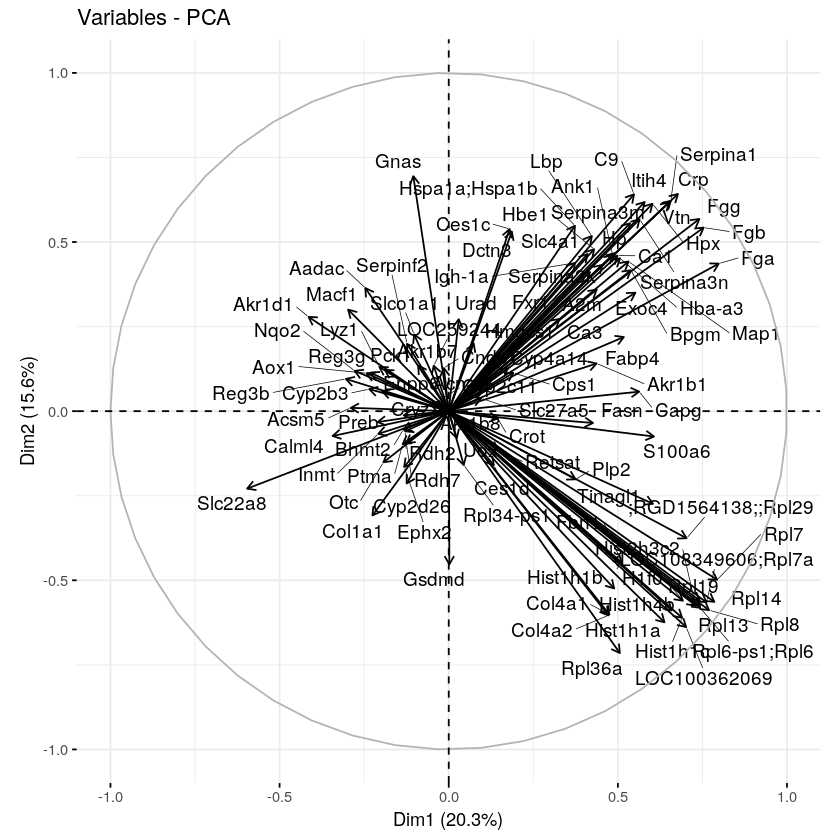

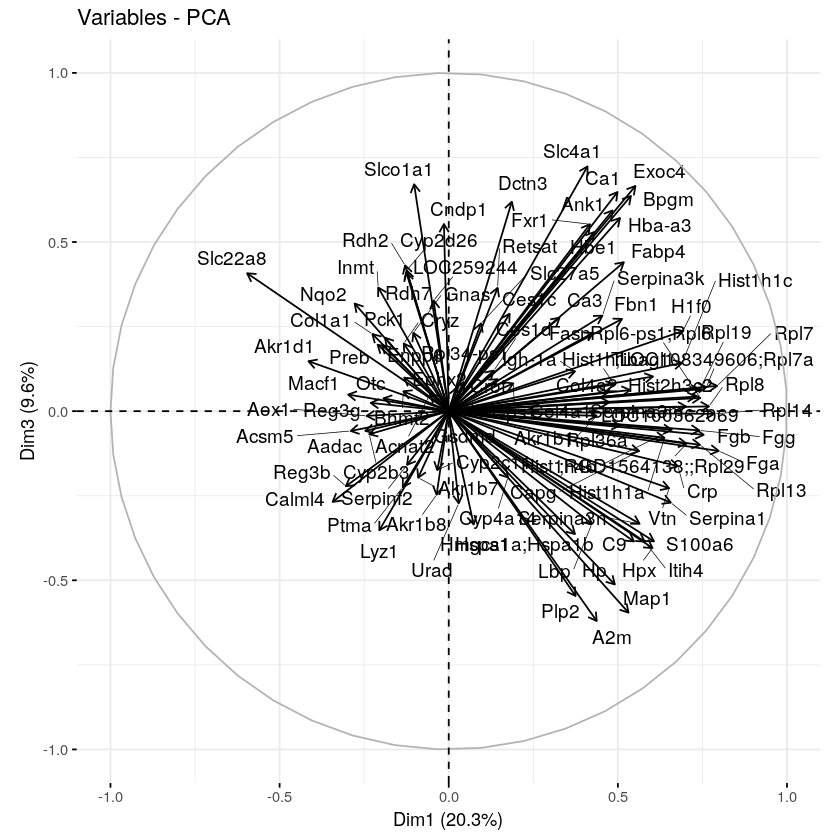

In [17]:
fviz_pca_var(proteome_norm_batch_pca_sub,
             col.ind = metadata$Treatment,
             addEllipses = FALSE,
             repel = TRUE,
             )
fviz_pca_var(proteome_norm_batch_pca_sub,
             axes = c(1,3),
             col.ind = metadata$Treatment,
             addEllipses = FALSE,
             repel = TRUE,
             )

The variable plot suggests that there are clusters of correlated proteins driving separation of the groups along PCs 1 and 2 and maybe 3.  The length informs contribution strength while direction determines effect on PC.

We can also combine these two views to make a biplot which shows all of the data points and associations on the same plot.  This makes it easier to see how different features (in this case, protein expressions) are driving the variability in the data.

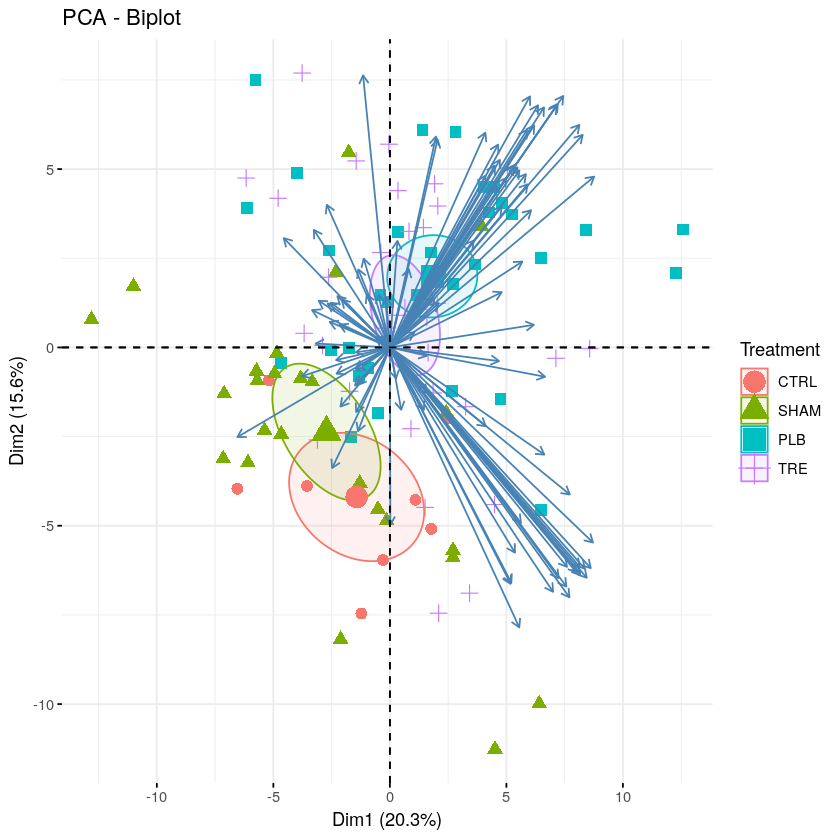

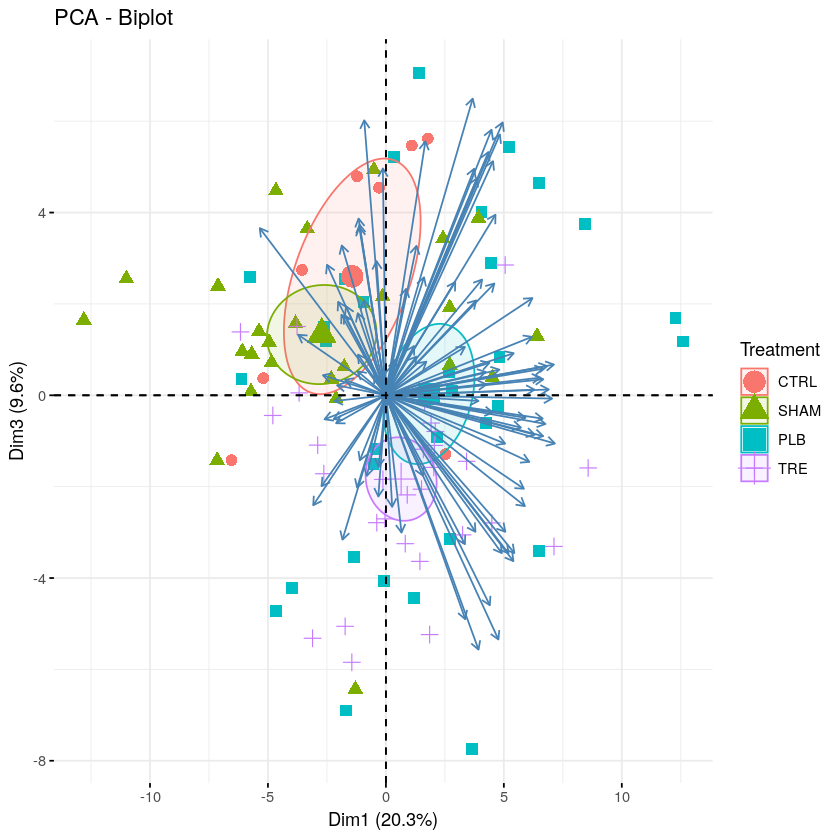

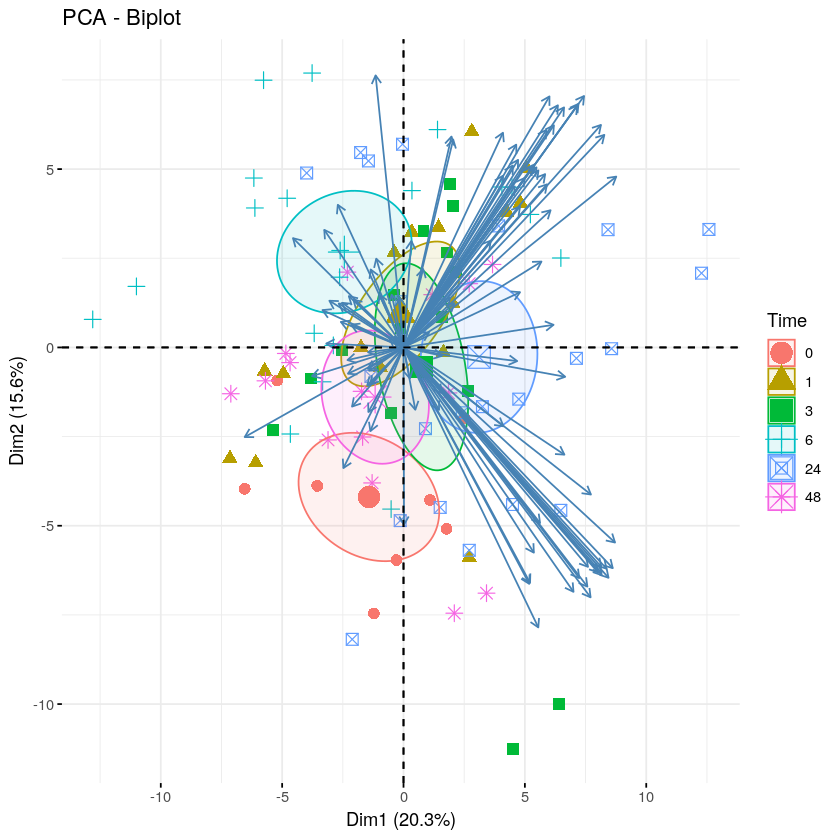

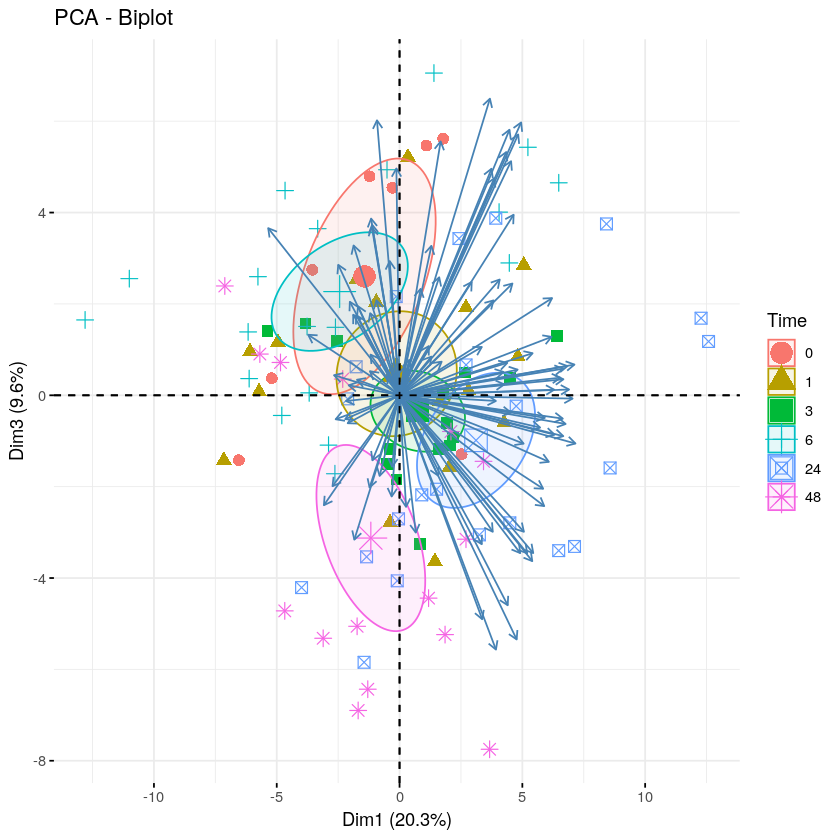

In [18]:
#compares the 1st vs 2nd PCs based on the Treatment variable
fviz_pca_biplot(proteome_norm_batch_pca_sub,
             col.ind = metadata$Treatment,
             addEllipses = TRUE,
             repel = TRUE,
             ellipse.type = "confidence",
             legend.title = "Treatment",
             pointsize = 3,
             label = "none"
             )
#compares the 1st vs 3nd PCs based on the Treatment variable
fviz_pca_biplot(proteome_norm_batch_pca_sub,
             axes = c(1,3),
             col.ind = metadata$Treatment,
             addEllipses = TRUE,
             repel = TRUE,
             ellipse.type = "confidence",
             legend.title = "Treatment",
             pointsize = 3,
             label = "none"
             )
#compares the 1st vs 2nd PCs based on the Time variable
fviz_pca_biplot(proteome_norm_batch_pca_sub,
             col.ind = metadata$Time,
             addEllipses = TRUE,
             repel = TRUE,
             ellipse.type = "confidence",
             legend.title = "Time",
             pointsize = 3,
             label = "none"
             )
#compares the 1st vs 3nd PCs based on the Time variable
fviz_pca_biplot(proteome_norm_batch_pca_sub,
             axes = c(1,3),
             col.ind = metadata$Time,
             addEllipses = TRUE,
             repel = TRUE,
             ellipse.type = "confidence",
             legend.title = "Time",
             pointsize = 3,
             label = "none"
             )

When we do differential analysis in the next sub-module, we should expect many of these same proteins to come out in the analysis.  Just as a second check, let's look at the data using classical multidimensional scaling (MDS).  MDS is a dimensionality reduction technique that uses a pairwise distance matrix generated from the data to map the data points into a new coordinate frame.

<div class="alert alert-block alert-warning">
<b>&#127891; Note:</b> PCA is a special case of MDS (MDS applied to Euclidean distances).
</div>

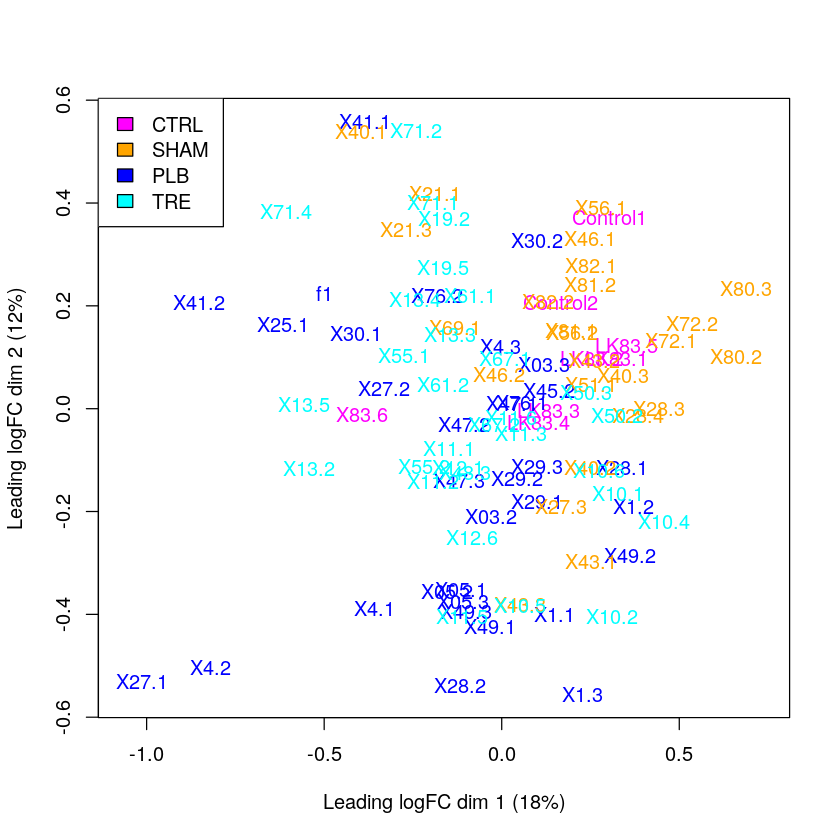

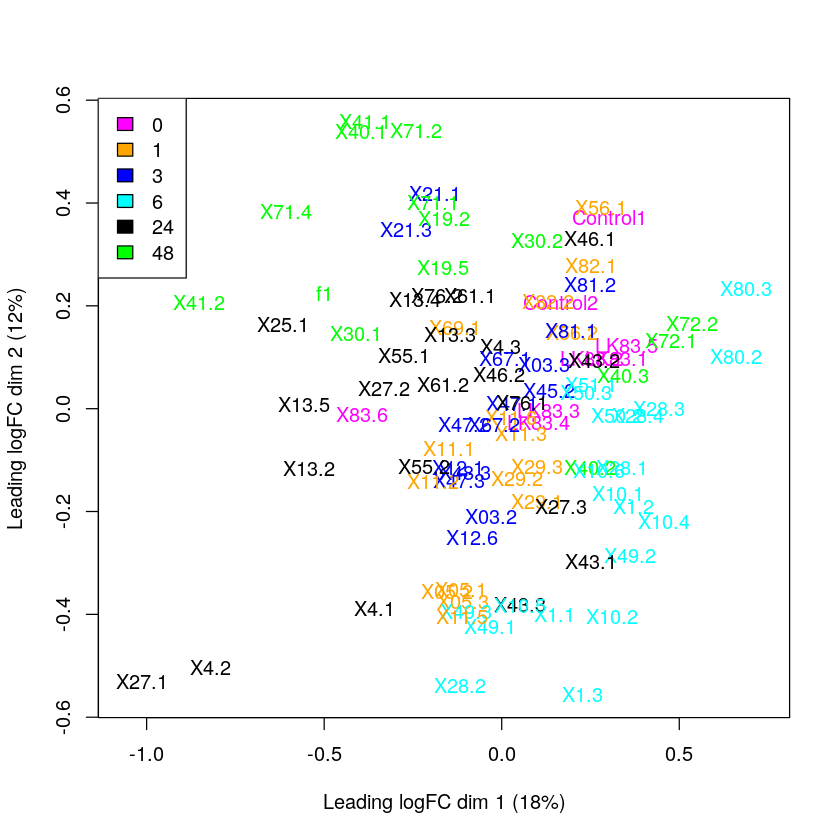

In [19]:
#MDS plot based on Treatment
col.cell <- c("magenta","orange", "blue", "cyan")[metadata$Treatment]
plotMDS(na.omit(proteome_norm_batch), col = col.cell)
legend("topleft",fill=c("magenta","orange", "blue", "cyan"),legend=levels(metadata$Treatment))

#MDS plot based on Time
col.cell <- c("magenta","orange", "blue", "cyan", "black", "green")[metadata$Time]
plotMDS(na.omit(proteome_norm_batch), col = col.cell)
legend("topleft",fill=c("magenta","orange", "blue", "cyan", "black", "green"),legend=levels(metadata$Time))

These plots are consistent with the PCA plots.  While the groupings are not as strongly separated as we would like, this is common in real data which is why the differential analysis is so important.  Now let's look at the data as a heat map to see if any patterns emerge.  First, we will <i>z</i>-scale the data which centers the data on 0 and makes it easier to distinguish differences.

In [20]:
scaled_data <- t(scale(t(proteome_norm_batch)))

Now we'll build a heatmap using BioConductor's <b>ComplexHeatmap</b> package.  First we'll define the annotations using the <i>HeatmapAnnotation</i> and then send those annotations to the <i>Heatmap</i> function.  Our annotations will include colored column labels for our two covariates (Treatment and Time) with accompanying legends.

<div class="alert alert-block alert-info">
    <b>&#9995; Tip:</b> There are many ways to generate heatmaps in R.  We use <b>ComplexHeatmap</b> because it's part of BioConductor and it easily makes customizable publication quality figures.  Others options inclued the <b>heatmaps</b> package in BioConductor, the <i>heatmap.2</i> function in the <b>gplots</b> package, the <i>geom_tile</i> geometry in <b>ggplot2</b></div>

The automatically generated colors map from the minus and plus 99^th of
the absolute values in the matrix. There are outliers in the matrix
whose patterns might be hidden by this color mapping. You can manually
set the color to `col` argument.

Use `suppressMessages()` to turn off this message.



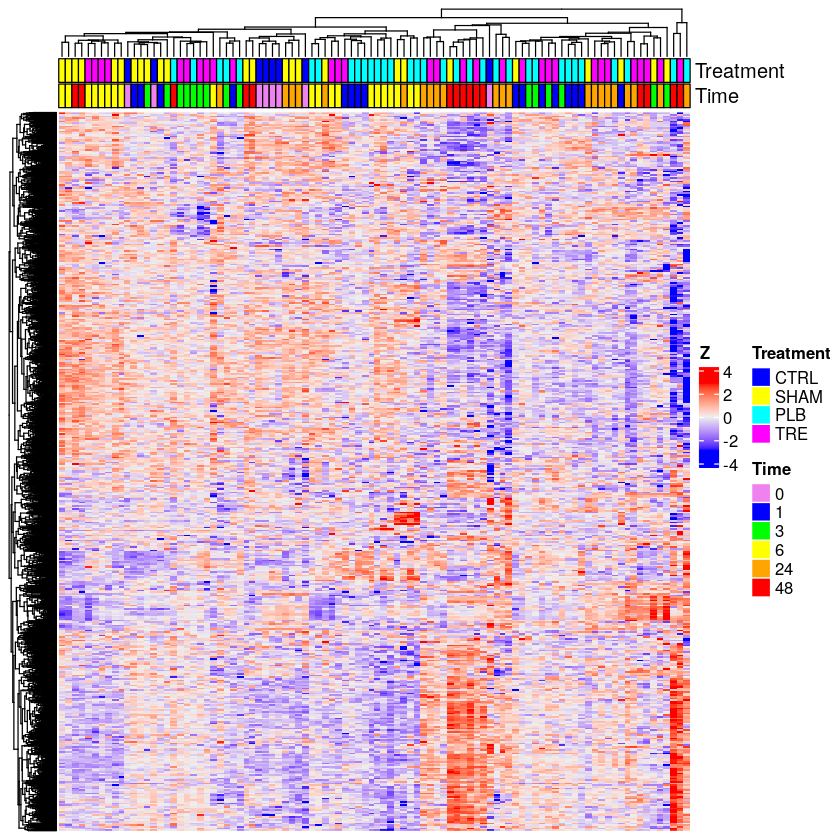

In [21]:
ht_opt$message = FALSE

# HeatmapAnnotation object
column_ha <- HeatmapAnnotation(
    Treatment = metadata$Treatment, 
    Time = metadata$Time,
  col = list(
    Treatment = c("CTRL" = "blue", "PLB" = "cyan", "SHAM" = "yellow", "TRE" = "magenta"),
    Time = c("0" = "violet", "1" = "blue", "3" = "green", "6" = "yellow", "24" = "orange", "48" = "red")
  ),
  gp = gpar(col = "black")
)

# Generate heatmap
Heatmap(
  scaled_data,
  name = "Z",
  top_annotation = column_ha,
  show_row_names = FALSE,
  show_column_names = FALSE
)

While we do see some patterns with the full data, it might be useful to pare this down to the most variable proteins.  Let's start with 50 for clarity.

In [22]:
#narrown data set to top 50 proteins
high_var_50 = order(apply(proteome_norm_batch, 1, var), decreasing=TRUE)[1:50]
scaled_data_50 <- t(scale(t(proteome_norm_batch[high_var_50,])))

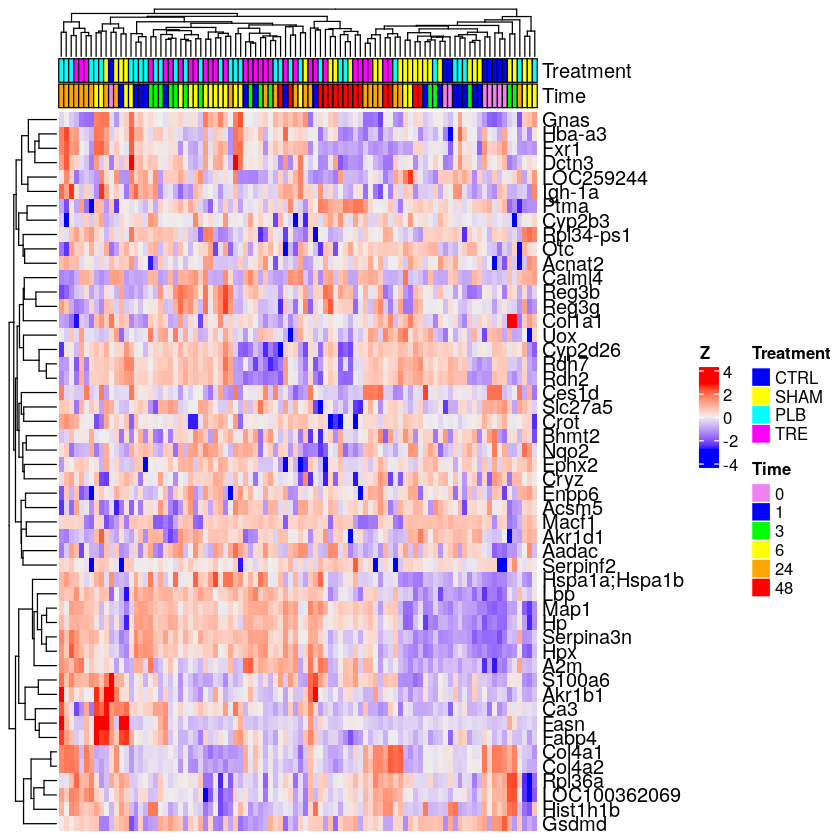

In [23]:
Heatmap(
  scaled_data_50,
  name = "Z",
  top_annotation = column_ha,
  show_row_names = TRUE,
  show_column_names = FALSE
)

In this view, we see many of the same genes that we saw appear in our biplot above.  There is some grouping based on Treatment and Time so we will try to account for this in the differential analysis in the next chapter.

Finally, we'll save our normalized data to our experimental object so that we don't have to regenerate it.

In [24]:
exp_obj$data$proteomics$norm <- proteome_norm
saveRDS(exp_obj, file = "data/Saved_Data/exp_obj.rds")

---

### Conclusions

Our exploratory analysis of the proteomic data suggests possible effects from both treatment state and time points affecting protein concentrations in the IRI samples.  We have identified proteins most variable between the sample groups and which may be potential biomarkers for different IRI states.  In the next chapter, we will conduct a proper differential analysis of the proteome data to determine which proteins are significantly changed between states.

---

<p><span style="font-size: 30px"><b>Quizzes</b></span> <span style="float : inline;">(run the command below to display the quizzes)</span> </p>

In [25]:
IRdisplay::display_html('<iframe src="quizes/Chapter7_Quizes.html" width=100% height=450></iframe>')

## References

[Hou J, Tolbert E, Birkenbach M, Ghonem NS. Treprostinil alleviates hepatic mitochondrial injury during rat renal ischemia-reperfusion injury. Biomed Pharmacother. 2021 Nov;143:112172. doi: 10.1016/j.biopha.2021.112172. Epub 2021 Sep 21. PMID: 34560548; PMCID: PMC8550798.][hou]<br>
[Ding M, Tolbert E, Birkenbach M, Gohh R, Akhlaghi F, Ghonem NS. Treprostinil reduces mitochondrial injury during rat renal ischemia-reperfusion injury. Biomed Pharmacother. 2021 Sep;141:111912. doi: 10.1016/j.biopha.2021.111912. Epub 2021 Jul 15. PMID: 34328097; PMCID: PMC8429269.][ding]<br>

[ding]: https://pubmed.ncbi.nlm.nih.gov/34328097/ "Ding M, Tolbert E, Birkenbach M, Gohh R, Akhlaghi F, Ghonem NS. Treprostinil reduces mitochondrial injury during rat renal ischemia-reperfusion injury. Biomed Pharmacother. 2021 Sep;141:111912. doi: 10.1016/j.biopha.2021.111912. Epub 2021 Jul 15. PMID: 34328097; PMCID: PMC8429269."
[hou]: https://pubmed.ncbi.nlm.nih.gov/34560548/ "Hou J, Tolbert E, Birkenbach M, Ghonem NS. Treprostinil alleviates hepatic mitochondrial injury during rat renal ischemia-reperfusion injury. Biomed Pharmacother. 2021 Nov;143:112172. doi: 10.1016/j.biopha.2021.112172. Epub 2021 Sep 21. PMID: 34560548; PMCID: PMC8550798."


---

In [26]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 10 (buster)

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.3.5.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] factoextra_1.0.7.999  lubridate_1.9.2       forcats_1.0.0        
 [4] stringr_1.5.0         dplyr_1.1.1           purrr_1.0.1          
 [7] readr_2.1.4           tidyr_1.3.0           tibble_3.2.1         
[10] ggplot2_3.4.1         tidyverse_2.0.0       plyr_1.8.8           
[13] ComplexHeatmap_2